In [128]:
from Wiki_Hurricane_Scraper import *
# from YouTube_Analytics import *
from FEMA_Scraper import *
from NOAA_Scraper import *
import os
import numpy as np
import pandas as pd
import seaborn as sns
import math
import matplotlib.pyplot as plt

In [139]:
def getDisasterInfo():
    hurricaneDf = getHurricaneData()
    hurricaneDf = hurricaneDf[hurricaneDf['Season'] >= 2005].set_index("Name")
    name = hurricaneDf.index.tolist()
    season = hurricaneDf['Season'].tolist()
    locations = getAllLocations()
    disastersInfo = list(zip(name, season))
    return hurricaneDf, disastersInfo, name, locations

def getFundingDf(funding, disastersInfo, name, locations):
    fundingdf = pd.DataFrame(columns=['Year'] + locations, index=name)
    for hurricane, locs in funding.items():
        for loc, funds in locs.items():
            fundingdf.at[hurricane, loc] = funds
    for name, year in disastersInfo:
        fundingdf.at[name, 'Year'] = year 
    fundingdf.rename(index=str, columns={"- Any -":"Total"}, inplace=True)
    return fundingdf

def getYoutubeDFs(disastersinfo):
    return getAllDisasterDfs(disastersInfo)

def getNOAAFunding(kwargs):
    return getFundingDataFromNOAA(**kwargs)

def processTweetDf(file):
    df = pd.read_csv(file)
    df['Total Exposure'] = df[['replies', 'retweets', 'likes']].sum(axis=1)
    df.drop(['link', 'id', 'location'], axis=1, inplace=True)
    return df

def processYoutubeDf(file):
    df = pd.read_csv(file, index_col=0).reset_index().drop('index', axis=1)
    df.drop(['Favourite Count', 'Video ID'], axis=1, inplace=True)
    return df

def getCompiledDf(fundingDf, hurricaneDf, tweets_by_hurricane, youtube_by_hurricane):
    columns = ['Tweet Count', 'Tweet Exposure', 'Hashtags', 'Video Count', 'Video Exposure',
                   'Youtube Tags']
    num_rows = len(tweets_by_hurricane)
    compiledDf = pd.DataFrame(columns=columns, index=hurricaneNames)
    compiledDf = compiledDf.merge(fundingDf[['Total','Year']], how='outer', left_index=True, right_index=True)
    compiledDf.rename(index=str, columns={"Total":"Funding"}, inplace=True)
    compiledDf = compiledDf.merge(hurricaneDf[['Damages']], how='outer', left_index=True, right_index=True)
    for hurricane in hurricaneNames:
        if hurricane in tweets_by_hurricane:
            tweets = tweets_by_hurricane[hurricane]
            compiledDf.loc[hurricane, 'Tweet Count'] = len(tweets)
            compiledDf.loc[hurricane, 'Tweet Exposure'] = sum(tweets['Total Exposure'])
            allhashes = [val.replace('\'', '') for res in tweets['hashtags'] if res != '[]' \
                                                 for val in res.replace('[', '').replace(']', '').split(', ')]
            compiledDf.loc[hurricane, 'Hashtags'] = ','.join(allhashes)
        vids = youtube_by_hurricane[hurricane]
        compiledDf.loc[hurricane, 'Video Count'] = len(vids)
        compiledDf.loc[hurricane, 'Video Exposure'] = sum(vids['Views'])
        allTags = [val.replace('\'', '') for res in vids['Tags'] if res != '[]' \
                                                 for val in res.replace('[', '').replace(']', '').split(', ')]
        compiledDf.loc[hurricane, 'Youtube Tags'] = ','.join(allTags)
#     compiledDf.fillna(value=0, inplace=True)
    return compiledDf

def plotFunding(df, xcol, log=True):
    temp = df.reset_index()
    temp = temp[temp['Funding']>1]
    if log:
        temp['Funding'] = np.log(temp['Funding'])
        temp[xcol] = np.log(temp[xcol])
    plt.figure(figsize=(5,5))
    ax = sns.lmplot(x=xcol, y='Funding', data=temp, hue='Name', fit_reg=False, legend=True)
    plt.show()

    
twitter_users_per_year = {2017: 328,
                          2016: 319,
                          2015: 305,
                          2014: 288,
                          2013: 241,
                          2012: 185,
                          2011: 117,
                          2010: 54
                            }

### Specified For U.S: Data for 2014-2017 was publicly available. Data for 2005-2013 was extrapolated using a
### quadratic fit on the found data: Formula: -0.817241 x^2 + 3300.01 x - 3.33117×10^6
youtube_users_per_year = {2017: 180.7,
                          2016: 176.1,
                          2015: 170.7,
                          2014: 163.5,
                          2013: 151.95,
                          2012: 140.04,
                          2011: 128.64,
                          2010: 114.74,
                          2009: 99.218,
                          2008: 82.06,
                          2007: 63.72,
                          2006: 42.58,
                          2005: 20.79
                          }


searchParamsFema = {'source' : 'https://www.fema.gov/disasters',
                'location' : 'Florida',
                'incidentType' : 'Hurricane',
                'declarationType' : 'DR',
                'startMonth' : 'January',
                'startYear' : 2013,
                'endMonth' : 'December',
                'endYear' : 2018,
                'disasterName' : 'Irma'}

searchQueryNOAA = {
    'eventType': '(Z) Storm Surge/Tide',
    'beginDate_mm': '01',
    'beginDate_dd': '01',
    'beginDate_yyyy': '2013',
    'endDate_mm': '12',
    'endDate_dd': '30',
    'endDate_yyyy': '2018',
    'county': 'ALL',
}


hurricaneDf, disastersInfo, hurricaneNames, locations = getDisasterInfo()

# funding = getAllFunding(disastersInfo, searchParamsFema)
# np.save("fundingDict.npy", funding)

### Collect The Fema Funds as a CSV File
# funding = np.load('fundingDict.npy').item()
# df = getFundingDf(funding, disastersInfo, hurricaneNames, locations)
# df.to_csv('fundingRaised.csv')

### Collect Youtube Stats as CSV file
# YouTubeDictDfs = getYouTubeDfs(disastersInfo)
# for idx, (key, value) in enumerate(YouTubeDictDfs.items()):
#     value.to_csv('YouTube Dataframes/'+key+'.csv')

In [72]:
### LOAD FUNDING DATAFRAME
fundingDf = pd.read_csv('fundingRaised.csv', index_col=0)
fundingDf.drop([col for col, val in fundingDf.sum().iteritems() if val == 0], axis=1, inplace=True)

### LOAD ALL TWEET DATAFRAMES
tweets_by_hurricane = {}
for file in os.listdir("tweet_csv"):
    hurricane = file.split('.')[0]
    tweets_by_hurricane[hurricane] = processTweetDf('tweet_csv/' + file)
    
### LOAD ALL YOUTUBE DATAFRAMES
youtube_by_hurricane = {}
for file in os.listdir("Youtube_Dataframes"):
    hurricane = file.split('.')[0]
    youtube_by_hurricane[hurricane] = processYoutubeDf('Youtube_Dataframes/' + file)
    
### Group Relevant Columns Together Across Df's
df = getCompiledDf(fundingDf, hurricaneDf, tweets_by_hurricane, youtube_by_hurricane)

In [73]:
### Adjusting Funding and Damages for Inflation at an average of 1.89% per year [CITE THIS]
inflationAdjustedDf = df.copy()
def calcInflation(row, col='Funding'):
    interest = np.power(1.0186, 2018-row['Year']+1)
    return row[col] * interest

inflationAdjustedDf['Funding'] = inflationAdjustedDf.apply(lambda row: calcInflation(row, col='Funding'), axis=1)
inflationAdjustedDf['Damages'] = inflationAdjustedDf.apply(lambda row: calcInflation(row, col='Damages'), axis=1)

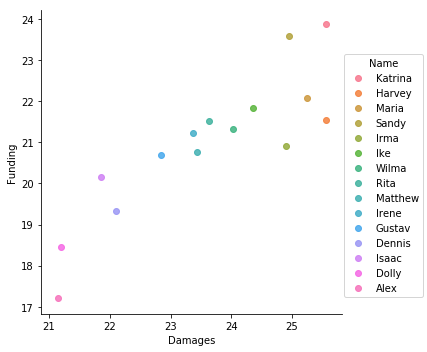

In [140]:
### Normal Image
plotFunding(df, 'Damages')

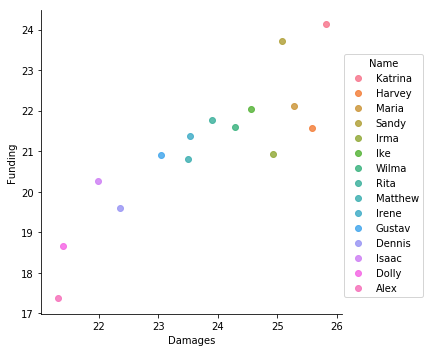

In [141]:
### Inflation Adjusted Plot
plotFunding(inflationAdjustedDf, 'Damages')

In [142]:
### Normalize Tweet and Video Exposures
normalizedYouTubeDf = inflationAdjustedDf.copy()
normalizedTweetDf = normalizedYouTubeDf[normalizedYouTubeDf.Year >= 2010]


normalizedTweetDf['Tweet Exposure'] = normalizedTweetDf.apply(lambda row: \
                                        row['Tweet Exposure']/(twitter_users_per_year[row.Year]-twitter_users_per_year[2010]), axis=1)

normalizedYouTubeDf['Video Exposure'] = normalizedYouTubeDf.apply(lambda row: \
                                            row['Video Exposure']/(youtube_users_per_year[row.Year]*1e6), axis=1)

/Users/sunil/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in long_scalars
  
/Users/sunil/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


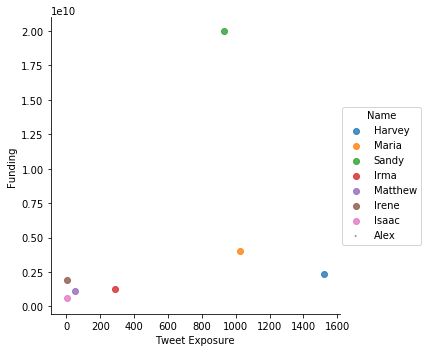

In [143]:
plotFunding(normalizedTweetDf, 'Tweet Exposure', log=False)

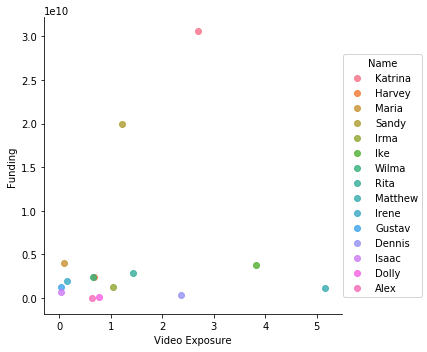

In [119]:
plotFunding(normalizedYouTubeDf, 'Video Exposure', log=False)

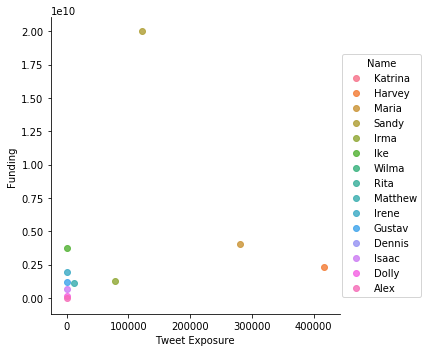

In [145]:
plotFunding(normalizedDf, 'Tweet Exposure', log=False)